In [43]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
import pandas as pd
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [45]:
# 랜덤 시드 고정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [46]:
df = pd.read_csv('경기도_아파트매매지수예측_변수.csv')
df

,Unnamed: 0,아파트매매지수,부동산심리지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,실업률,아파트거래량,지가변동률
0,0,90.1,114.70,2120.03,90.1810,3.42,3.69,3.300,11154,0.1500
1,1,90.5,113.20,2160.09,90.6130,3.52,3.73,2.800,11009,0.1480
2,2,90.6,107.80,1887.21,90.6131,3.56,3.74,3.100,12681,0.1300
3,3,90.3,105.00,1683.94,90.5270,3.54,3.76,3.110,13549,0.1310
4,4,89.4,102.30,1891.22,90.6132,3.59,3.78,3.200,12405,0.1290
...,...,...,...,...,...,...,...,...,...,...
153,153,137.0,100.51,2766.24,113.8900,3.71,3.95,3.112,11673,0.2170
154,154,137.1,109.22,2679.04,114.0100,3.70,3.96,2.770,11703,0.2280
155,155,138.1,121.90,2657.81,113.7600,3.77,3.96,2.850,12683,0.2221
156,156,139.3,125.20,2792.96,114.1600,3.80,3.95,2.430,16890,0.2240


In [47]:
# 날짜변수 Datetime으로 변환 (시계열 고려)
# df['날짜'] = pd.to_datetime(df['Unnamed: 0'], format='%Y년 %m월')

# 날짜 변수 제거
df = df.drop(columns = ['Unnamed: 0', '실업률', '부동산심리지수'])

# 모멘텀 만들 때, 거래량 0이면 inf값 발생 => 아파트 거래량이 0이 애들 10.00001로 변경
df['아파트거래량'] = np.where(df['아파트거래량']==0, 0.00001, df['아파트거래량'])

In [48]:
# 방향성 y값 생성
df['방향성'] = (df['아파트매매지수'].diff() > 0).astype(int) # 1 if increase, 0 if decrease
df['방향성'] = df['방향성'].shift(-1)

# df = df.dropna()

In [49]:
columns = df.drop(columns=["방향성"]).columns
columns

Index(['아파트매매지수', 'kospi', '소비자물가지수', 'New_COFIX', 'Outstanding_COFIX',
       '아파트거래량', '지가변동률'],
      dtype='object')

In [50]:
# 변동성 특성 추가

lags = [1, 3, 6, 12]  # 시차 변수: 1개월 전, 3개월 전, 6개월 전, 12개월 전


# 변수 생성
for col in columns:
    # 변화율
    df[f'{col}_변화율'] = df[col].pct_change(fill_method=None).fillna(0)
    # 이동평균
    df[f'{col}_이동평균'] = df[col].rolling(window=3, min_periods=1).mean()
    # 변동성
    df[f'{col}_변동성'] = df[col].rolling(window=5, min_periods=1).std().bfill()
    # 모멘텀
    df[f'{col}_모멘텀'] = df[col].pct_change(periods=3, fill_method=None).fillna(0)
    # 시차 변수 생성
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# NA 값 제거
df2 = df.copy()
df = df.dropna()
df

,아파트매매지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,아파트거래량,지가변동률,방향성,아파트매매지수_변화율,아파트매매지수_이동평균,...,아파트거래량_lag6,아파트거래량_lag12,지가변동률_변화율,지가변동률_이동평균,지가변동률_변동성,지가변동률_모멘텀,지가변동률_lag1,지가변동률_lag3,지가변동률_lag6,지가변동률_lag12
12,85.20,1864.73,91.375,3.69,3.83,7443.0,0.0950,0.0,-0.010453,86.000000,...,3300.0,11154.0,-0.144144,0.106000,0.009397,-0.173913,0.1110,0.115,0.113,0.1500
13,84.70,1870.58,91.738,3.70,3.80,6215.0,0.0490,0.0,-0.005869,85.333333,...,7769.0,11009.0,-0.484211,0.085000,0.027619,-0.562500,0.0950,0.112,0.108,0.1480
14,84.50,1909.06,92.387,3.56,3.76,5711.0,0.0260,0.0,-0.002361,84.800000,...,10739.0,12681.0,-0.469388,0.056667,0.038978,-0.765766,0.0490,0.111,0.120,0.1300
15,84.40,1998.52,92.180,3.44,3.73,10384.0,0.0590,0.0,-0.001183,84.533333,...,9639.0,13549.0,1.269231,0.044667,0.034583,-0.378947,0.0260,0.095,0.115,0.1310
16,83.80,1903.57,91.903,3.56,3.71,11093.0,0.0580,0.0,-0.007109,84.233333,...,8896.0,12405.0,-0.016949,0.047667,0.024866,0.183673,0.0590,0.049,0.112,0.1290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,136.61,2664.52,113.900,3.69,3.95,10104.0,0.2110,1.0,0.000073,136.470000,...,10076.0,9903.0,0.076531,0.196000,0.011305,0.093264,0.1960,0.193,0.137,0.0291
153,137.00,2766.24,113.890,3.71,3.95,11673.0,0.2170,1.0,0.002855,136.736667,...,8242.0,9218.0,0.028436,0.208000,0.014450,0.198895,0.2110,0.181,0.168,0.0380
154,137.10,2679.04,114.010,3.70,3.96,11703.0,0.2280,1.0,0.000730,136.903333,...,7407.0,10670.0,0.050691,0.218667,0.018393,0.163265,0.2170,0.196,0.187,0.0581
155,138.10,2657.81,113.760,3.77,3.96,12683.0,0.2221,1.0,0.007294,137.400000,...,6081.0,10633.0,-0.025877,0.222367,0.012250,0.052607,0.2280,0.211,0.193,0.0671


In [51]:
X = df.drop(columns = ['방향성', '아파트매매지수'])
y = df['방향성']

In [52]:
# train_test분리
train_size = int(len(X) * 0.7) 
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# # 데이터 분리 비율 설정
# train_size = int(len(X) * 0.7)  # 70% Train
# val_size = int(len(X) * 0.15)  # 15% Validation
# test_size = len(X) - train_size - val_size  # 나머지 15% Test

# # 데이터 분리
# X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
# y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# # 각 데이터셋 크기 확인
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((101, 62), (44, 62), (101,), (44,))

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# TimeSeriesSplit 객체 생성
tscv = TimeSeriesSplit(n_splits=5)  # 시계열 교차 검증 분할 수

# 하이퍼파라미터 설정
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],     # 정규화 강도
    'model__penalty': ['l1', 'l2'],          # 규제 종류
    'model__solver': ['liblinear', 'saga']   # 최적화 알고리즘
}

# LogisticRegression 초기화
logistic = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline 생성 (StandardScaler + LogisticRegression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature 스케일링
    ('model', logistic)
])

# GridSearchCV 초기화
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',   # 평가 기준
    cv=tscv,              # TimeSeriesSplit 사용
    verbose=2,            # 진행 상황 출력
    n_jobs=-1             # 병렬 처리
)

# GridSearchCV 실행 (Train 데이터에 대해 수행)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__C=0.01, model__penalty=l1, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l1, model__solver=saga; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l1, model__solver=saga; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] E

/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Lib

[CV] END model__C=100, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] END model__C=100, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] END model__C=100, model__penalty=l1, model__solver=saga; total time=   0.1s
[CV] END model__C=100, model__penalty=l2, model__solver=saga; total time=   0.0s
[CV] END model__C=100, model__penalty=l2, model__solver=saga; total time=   0.0s


/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [55]:
# 최적의 하이퍼파라미터와 점수 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best Cross-Validation Accuracy: 0.8


In [56]:
# Validation 데이터 평가 (최적의 모델 사용)
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest F1_Score:", f1_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.6590909090909091

Test F1_Score: 0.7945205479452054

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        15
         1.0       0.66      1.00      0.79        29

    accuracy                           0.66        44
   macro avg       0.33      0.50      0.40        44
weighted avg       0.43      0.66      0.52        44



/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Text(50.722222222222214, 0.5, 'True Label')

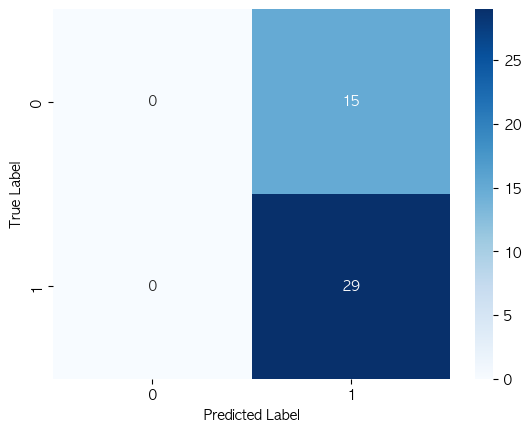

In [57]:
cf = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cf, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [58]:
tmp = df2.drop(columns='방향성')

X_future = tmp.loc[[157]]

In [59]:
best_model.predict(X_future)

/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: X has 63 features, but StandardScaler is expecting 62 features as input.

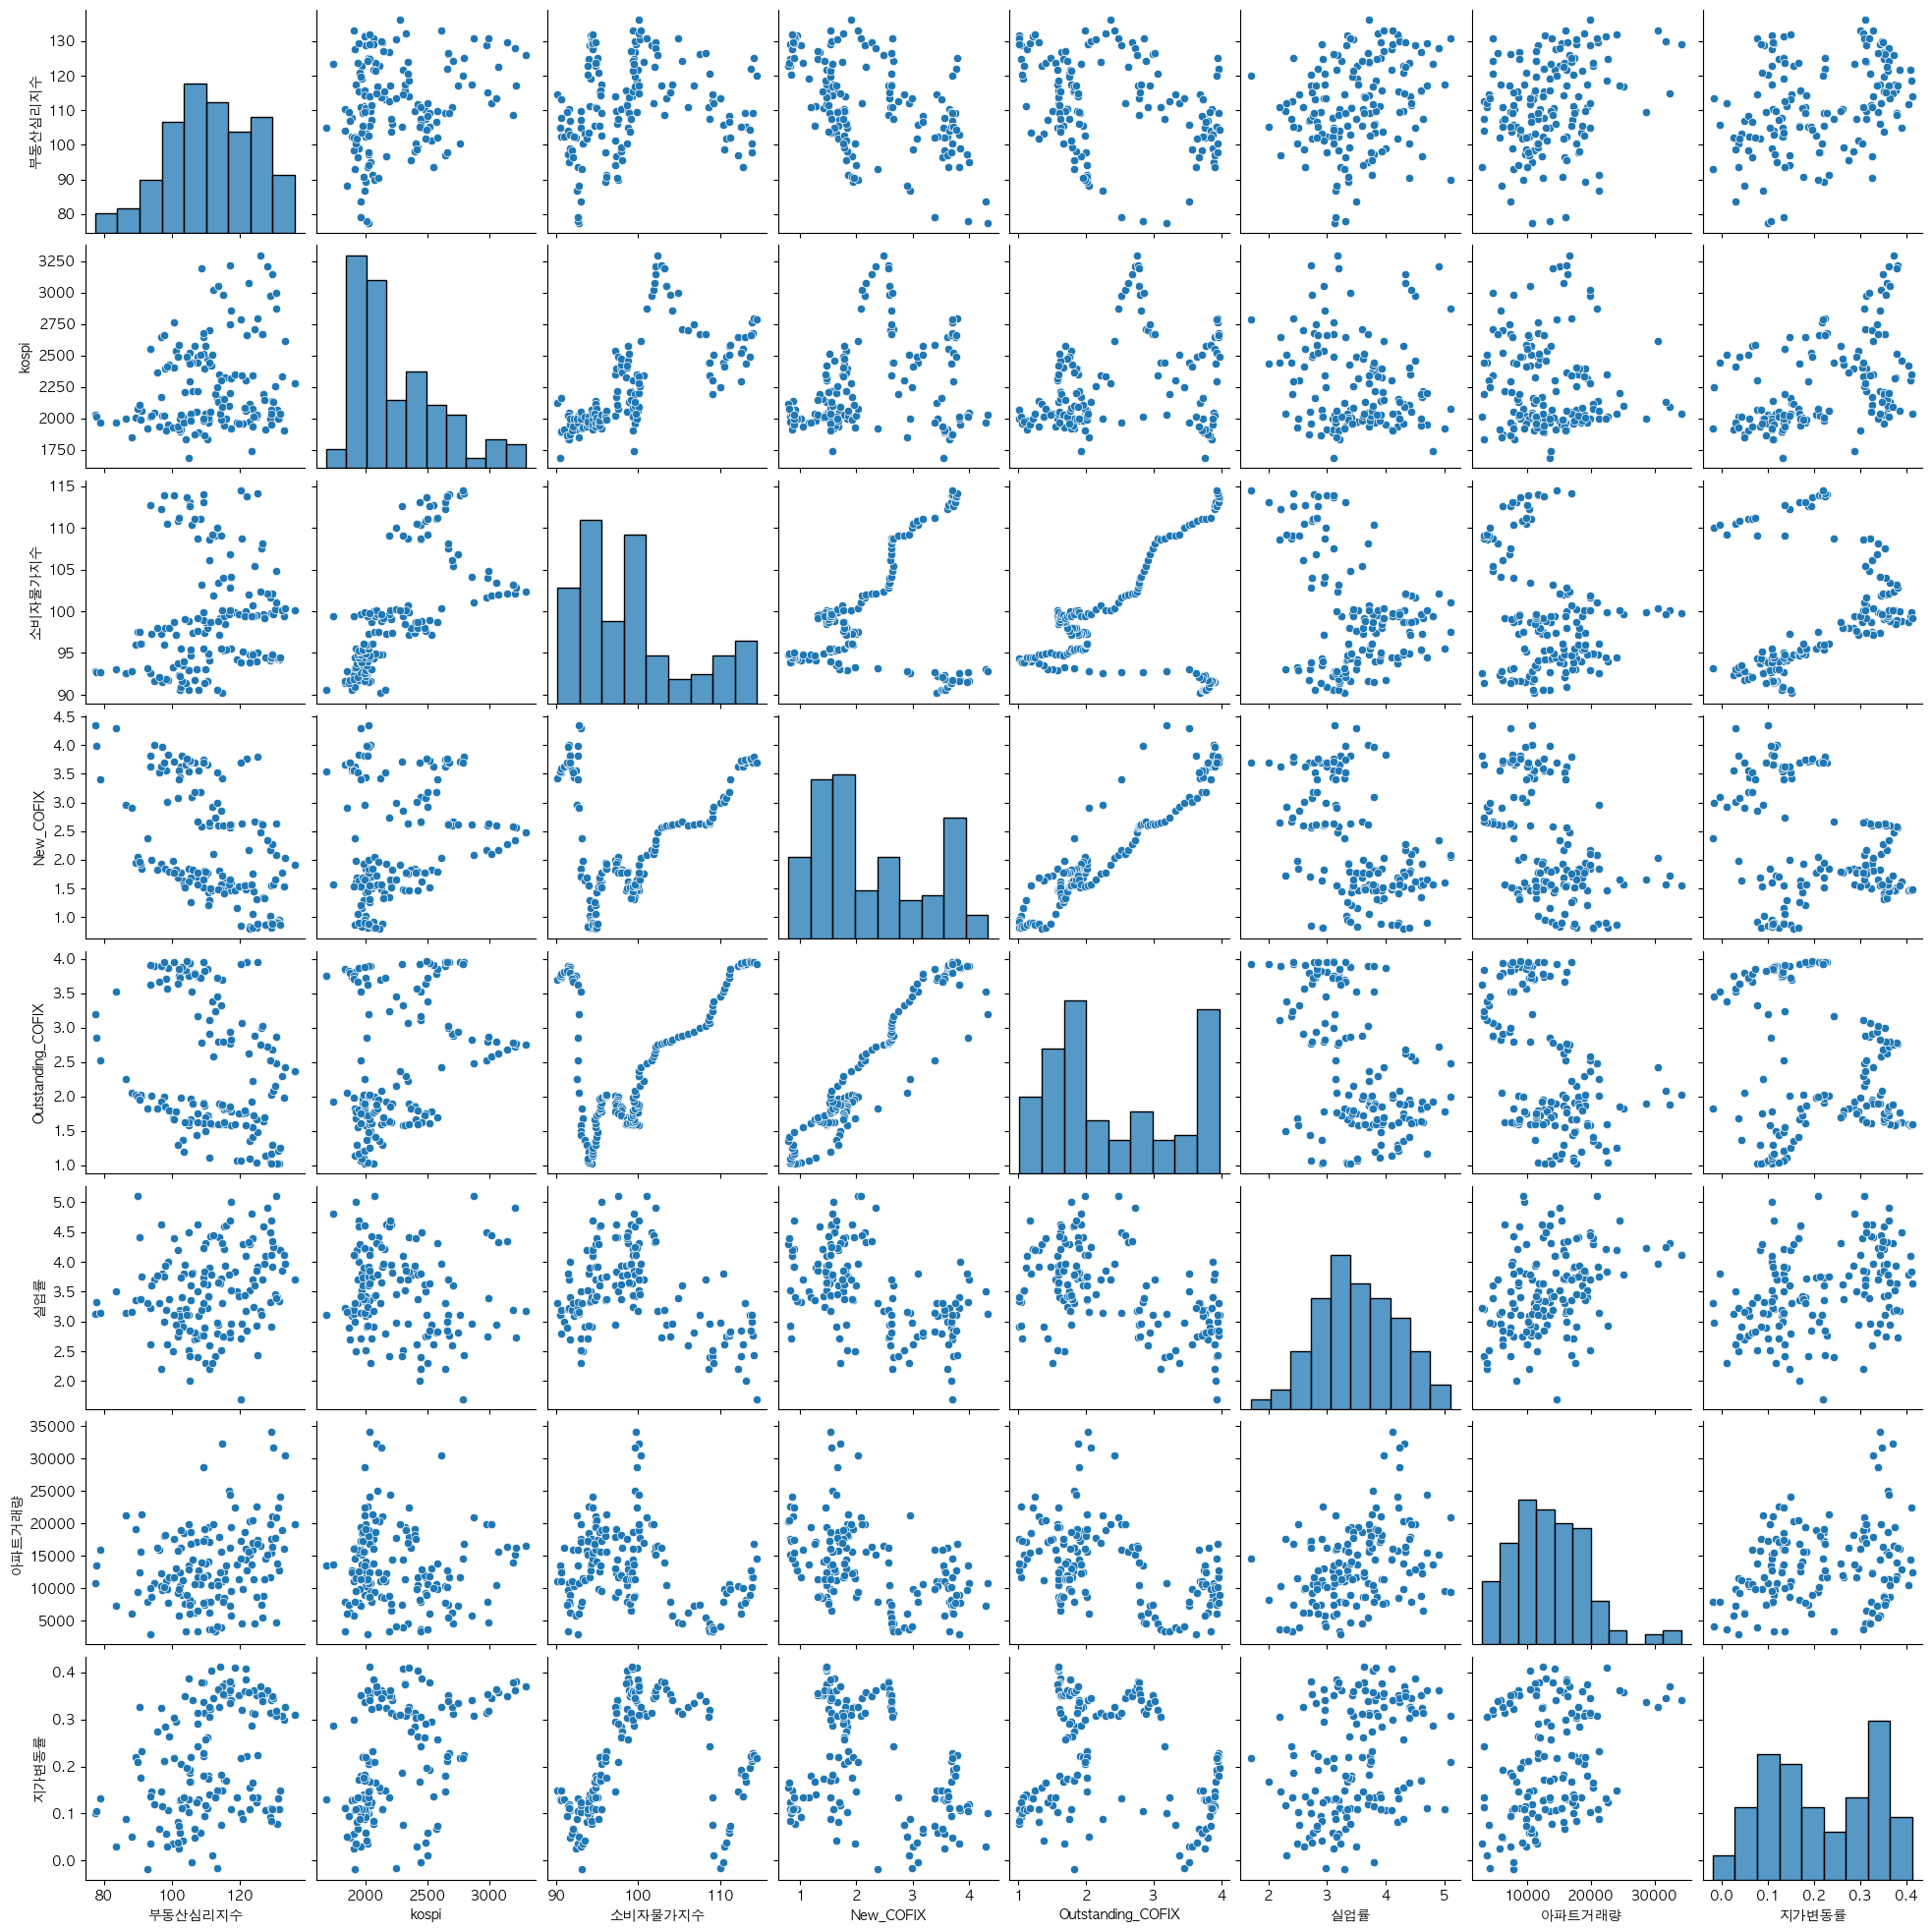

In [ ]:
##데이터 시각화
df = pd.read_csv('경기도_아파트매매지수예측_변수.csv')

columns = df.drop(columns = ['아파트매매지수', 'Unnamed: 0']).columns

sns.pairplot(df[columns])
plt.show()

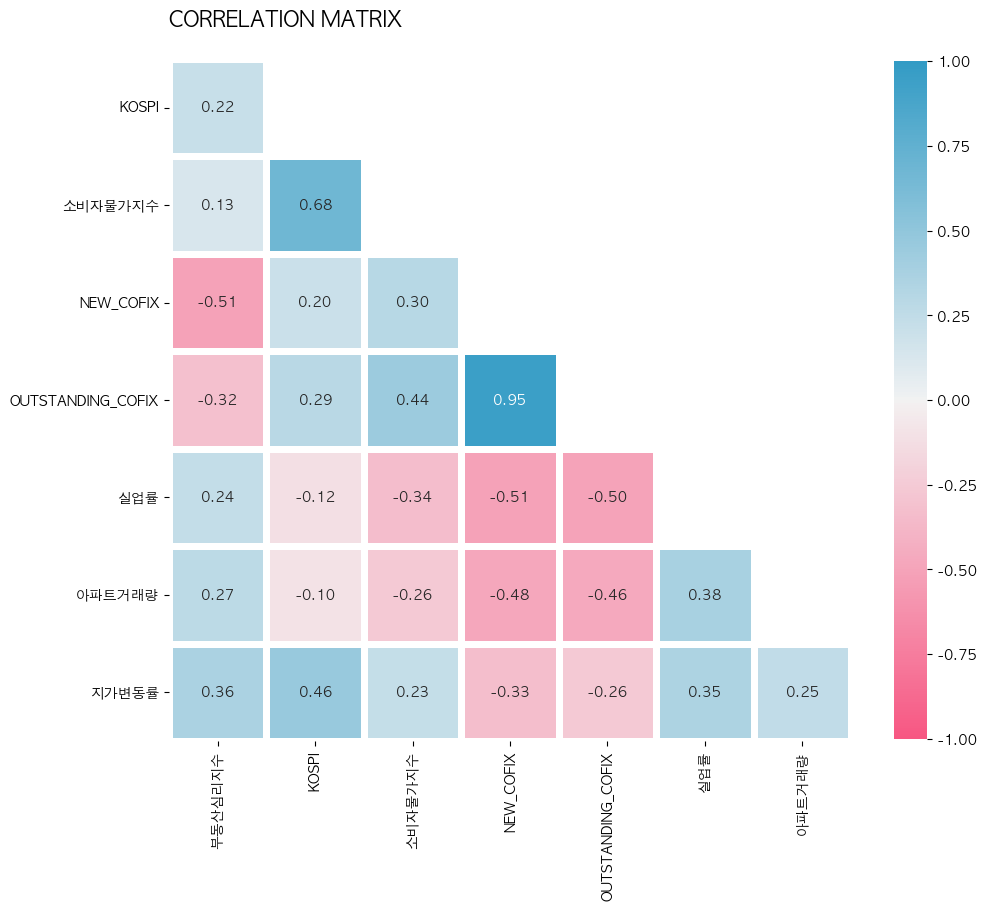

In [ ]:
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

# 상관관계
ig, ax = plt.subplots(figsize=(11, 11))
df_corr = df[columns].corr()

# mask
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
            linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
            cbar_kws={"shrink": .8}, square=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=15)
plt.show()

In [ ]:
df = df.drop(columns = 'Outstanding_COFIX')

In [ ]:
columns = df.drop(columns = ['아파트매매지수', 'Unnamed: 0']).columns

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[columns], i) for i in range(df[columns].shape[1])]
vif["features"] = df[columns].columns
vif

,VIF Factor,features
0,111.202536,부동산심리지수
1,96.441490,kospi
2,218.420217,소비자물가지수
3,13.288022,New_COFIX
4,31.247384,실업률
5,7.889402,아파트거래량
6,7.607919,지가변동률
